In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

from CoilSystem import CoilSystem
from InductanceSolver import InductanceSolver
from TransientResponse import TransientResponse
from InductanceCalculator import InductanceCalculator

In [2]:
cs = CoilSystem(data_dir = 'coil_data', L_filename = 'L.csv')
cs.disable_coils()
cindex = cs.get_cindex()

#inc = InductanceCalculator(coil_system = cs, initial_L = cs.L)
#inc.compute_L(write_loc = 'coil_data/L_recomputed.csv')

ins = InductanceSolver(coil_system = cs, 
                       waveform_dir = 'waveform_data',
                       feedback_supression = 1e4)

sol = ins.solve_system(ntimesteps = 10000)

tr = TransientResponse(coil_system = cs, 
                       inductance_solution = sol)

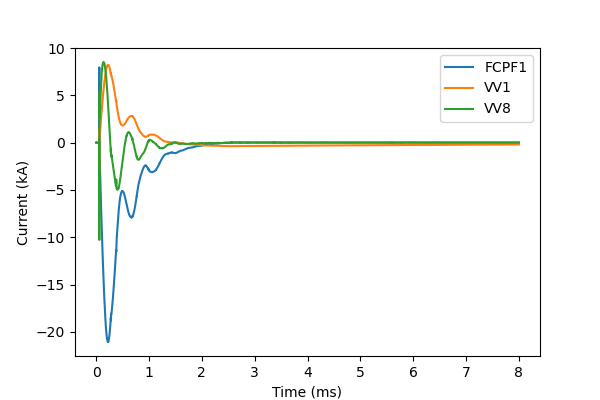

In [3]:
### Plot Coil Currents 

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for coil_name in ['FCPF1', 'VV1', 'VV8']:
    plt.plot(sol.t * 1e3, sol.y[cindex[coil_name]] * 1e-3, label = coil_name)

plt.xlabel('Time (ms)')
plt.ylabel('Current (kA)')
plt.legend()
plt.show()

<>:86: SyntaxWarning: invalid escape sequence '\m'
<>:86: SyntaxWarning: invalid escape sequence '\m'
C:\Users\adamt\AppData\Local\Temp\ipykernel_39012\3925809462.py:86: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f'$t =${sol.t[tindex] / 1e-6:.1f} $\mu$s \n I_PFA = I_PFB = {-pf_a_current * 1e-3:.1f} kA')


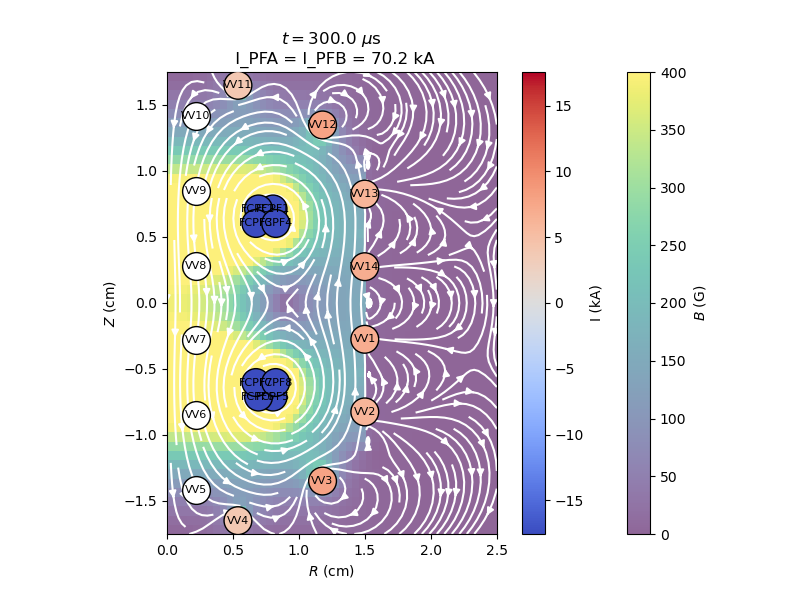

In [9]:
# ======= SETUP =======

#tindex = tr.tindex(224e-6)
tindex_peiyun = tr.tindex(189.7e-6) # peiyun calc time 
tindex_euichan = tr.tindex(100e-6)
tindex_jongsoo = tr.tindex(192e-6)
tindex_max = tr.tindex(230e-6)
tindex_ansys = tr.tindex(240e-6)
tindex_email = tr.tindex(300e-6)

tindex = tindex_email

all = cs.coil_names
far_wall = ['VV1', 'VV2', 'VV13', 'VV14']
bent_walls = ['VV12', 'VV3', 'VV11', 'VV4']
center_stack = ['VV5', 'VV6', 'VV7', 'VV8', 'VV9', 'VV10']
pf_coils = ['FCPF1', 'FCPF2', 'FCPF3', 'FCPF4', 'FCPF5', 'FCPF6', 'FCPF7', 'FCPF8']
pf_a = ['FCPF1', 'FCPF2', 'FCPF3', 'FCPF4']
pf_b = ['FCPF5', 'FCPF6', 'FCPF7', 'FCPF8']
rest = [x for x in all if x not in far_wall and x not in bent_walls]
not_center_stack = [x for x in all if x not in center_stack]

activated_coils = not_center_stack
#activated_coils = pf_coils

# ======= COMPUTATION =======

GRID_N = 50

R_vals = np.linspace(0, 2.5, GRID_N)
Z_vals = np.linspace(-1.75,  1.75, GRID_N)

#R_vals = np.linspace(1.4, 2.3, GRID_N)
#Z_vals = np.linspace(-0.5, 0.5, GRID_N)

Rs, Zs = np.meshgrid(R_vals, Z_vals)

Br_grid = np.zeros_like(Rs)
Bz_grid = np.zeros_like(Zs)

B_CUTOFF = 400

for i in range(Rs.shape[0]):
    for j in range(Rs.shape[1]):
        Br_grid[i, j], Bz_grid[i, j] = tr.calculate_field(tindex, Rs[i, j], Zs[i, j], activated_coils = activated_coils)

# ======= PLOTTING =======

plt.figure(figsize=(8, 6))

activated_mask = np.isin(cs.coil_names, activated_coils)

coil_positions_r = cs.coil_coords[:, 0]
coil_positions_z = cs.coil_coords[:, 1]
coil_currents = sol.y[:, tindex]

vmax = np.max(np.abs(coil_currents / 1e3))

# === PLOT MAGNETIC FIELD ===

B_mag = np.sqrt(Br_grid**2 + Bz_grid**2)
plt.imshow(B_mag * 1e4, extent=[R_vals.min(), R_vals.max(), Z_vals.min(), Z_vals.max()],
                origin='lower', aspect='auto', cmap='viridis', alpha=0.6, vmin=0, vmax=B_CUTOFF)
plt.colorbar(label='$B$ (G)')

plt.streamplot(Rs, Zs, Br_grid, Bz_grid, density=1.5, color = 'white')

# === PLOT COILS ===

sc = plt.scatter(coil_positions_r[activated_mask], coil_positions_z[activated_mask], c=coil_currents[activated_mask] / 1e3, s=400, cmap='coolwarm', edgecolors='black', zorder=3, vmin=-vmax, vmax=vmax)
plt.colorbar(sc, label='I (kA)')

plt.scatter(coil_positions_r[~activated_mask], coil_positions_z[~activated_mask], c='white', s=400, edgecolors='black', zorder=2, label='Inactive coils')

for idx, (r, z) in enumerate(zip(coil_positions_r, coil_positions_z)):
    plt.text(r, z, cs.coil_names[idx], color='black', fontsize=8, ha='center', va='center', zorder=4)

pf_a_current = coil_currents[cs.get_cindex()['FCPF1']] + coil_currents[cs.get_cindex()['FCPF2']] + \
                coil_currents[cs.get_cindex()['FCPF3']] + coil_currents[cs.get_cindex()['FCPF4']]
 
plt.xlabel('$R$ (cm)')
plt.ylabel('$Z$ (cm)')
plt.xlim([min(R_vals), max(R_vals)])
plt.ylim([Z_vals.min(), Z_vals.max()])
plt.gca().set_aspect('equal')
plt.title(f'$t =${sol.t[tindex] / 1e-6:.1f} $\mu$s \n I_PFA = I_PFB = {-pf_a_current * 1e-3:.1f} kA')

plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
C:\Users\adamt\AppData\Local\Temp\ipykernel_39012\112160059.py:37: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f'$B_z$ vs. $R$ @ $Z=${Z_sel * 100:.1f} cm \n t = {sol.t[tindex] / 1e-6:.1f} $\mu$s, I = {-pf_a_current * 1e-3:.1f} kA')


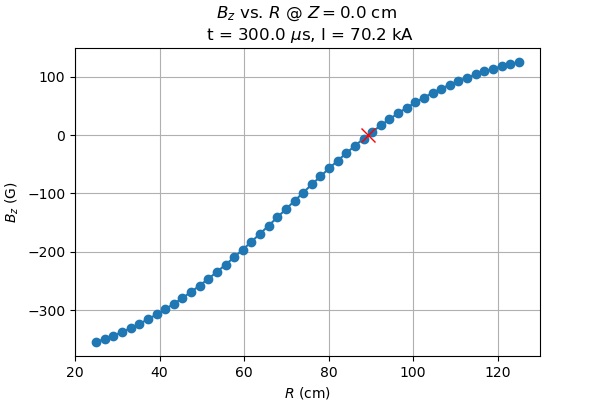

In [ ]:
# === SETUP === 

#tindex = tr.tindex(100e-6)
Z_sel = 0.0
R1 = 25
R2 = 125

N_POINTS = 50

# === PLOTTING ===

Z_sel /= 100
R1 /= 100
R2 /= 100

R_cut = np.linspace(R1, R2, N_POINTS)
Bz_cut = np.array([tr.calculate_field(tindex, r, Z_sel, activated_coils=activated_coils)[1] for r in R_cut])

# Find zero crossings
zero_crossings = np.where(np.diff(np.sign(Bz_cut)))[0]

plt.figure(figsize=(6, 4))

plt.plot(R_cut * 100, Bz_cut * 1e4, marker='o')

for idx in zero_crossings:
    # Linear interpolation for more accurate zero crossing
    r0 = R_cut[idx]
    r1 = R_cut[idx + 1]
    b0 = Bz_cut[idx]
    b1 = Bz_cut[idx + 1]
    r_zero = r0 - b0 * (r1 - r0) / (b1 - b0)
    plt.plot(r_zero * 1e2, 0, 'rx', markersize=10, label='Zero crossing' if idx == zero_crossings[0] else "")

plt.xlabel('$R$ (cm)')
plt.ylabel('$B_z$ (G)')
plt.title(f'$B_z$ vs. $R$ @ $Z=${Z_sel * 100:.1f} cm \n t = {sol.t[tindex] / 1e-6:.1f} $\mu$s, I = {-pf_a_current * 1e-3:.1f} kA')
plt.grid(True)
plt.show()

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
C:\Users\adamt\AppData\Local\Temp\ipykernel_39012\3148042575.py:44: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f'$B_z$ vs. $R$ @ $Z$={Z_sel * 100:.1f} cm\n t = {sol.t[tindex] / 1e-6:.1f} $\mu$s')


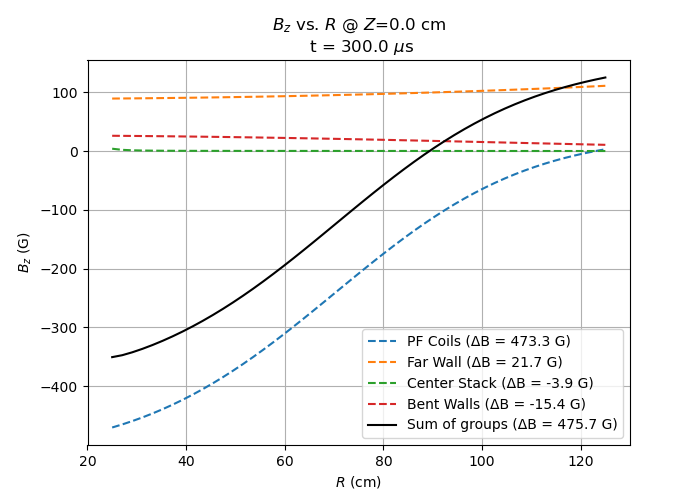

In [12]:
# === SETUP === customizable Bz profile breakdown

def plot_Bz_profile_groups(R_cut, Z_sel, tindex, coil_groups, group_labels=None, colors=None):
    """
    Plot Bz(R) at Z_sel for each group of coils in coil_groups, their sum, and the total Bz.
    
    Parameters:
        R_cut: 1D array of R values (meters)
        Z_sel: float, Z value (meters)
        tindex: int, time index
        coil_groups: list of lists, each sublist is a group of coil names
        group_labels: list of str, labels for each group (optional)
        colors: list of str, colors for each group (optional)
    """
    if group_labels is None:
        group_labels = [f'Group {i+1}' for i in range(len(coil_groups))]
    if colors is None:
        colors = plt.cm.tab10.colors

    # Compute Bz for each group
    group_Bz = []
    group_deltas = []
    for group in coil_groups:
        Bz = np.array([tr.calculate_field(tindex, r, Z_sel, activated_coils=group)[1] for r in R_cut])
        group_Bz.append(Bz)
        delta = (Bz[-1] - Bz[0]) * 1e4  # in Gauss
        group_deltas.append(delta)

    # Sum of groups
    sum_Bz = np.sum(group_Bz, axis=0)
    sum_delta = (sum_Bz[-1] - sum_Bz[0]) * 1e4  # in Gauss

    # Total Bz (all coils)
    total_Bz = np.array([tr.calculate_field(tindex, r, Z_sel, activated_coils=all)[1] for r in R_cut])
    total_delta = (total_Bz[-1] - total_Bz[0]) * 1e4  # in Gauss

    plt.figure(figsize=(7, 5))
    for i, Bz in enumerate(group_Bz):
        label = f"{group_labels[i]} (ΔB = {group_deltas[i]:.1f} G)"
        plt.plot(R_cut * 100, Bz * 1e4, '--', label=label, color=colors[i % len(colors)])
    plt.plot(R_cut * 100, sum_Bz * 1e4, color='black', label=f'Sum of groups (ΔB = {sum_delta:.1f} G)')
    plt.xlabel('$R$ (cm)')
    plt.ylabel('$B_z$ (G)')
    plt.title(f'$B_z$ vs. $R$ @ $Z$={Z_sel * 100:.1f} cm\n t = {sol.t[tindex] / 1e-6:.1f} $\mu$s')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage: split into PF coils and vessel coils
pf_group = pf_coils
vessel_group = [name for name in all if name not in pf_coils]
plot_Bz_profile_groups(
    R_cut=R_cut,
    Z_sel=Z_sel,
    tindex=tindex,
    coil_groups=[pf_group, far_wall, center_stack, bent_walls],
    group_labels=['PF Coils', 'Far Wall', 'Center Stack', 'Bent Walls']
)